<a id="setup"></a>
## Setup

This notebook was tested using the following Docker container:

* `nvcr.io/nvidia/rapidsai/rapidsai:0.9-cuda10.0-runtime-ubuntu18.04` from [Nvidia GPU Cloud - NGC](https://ngc.nvidia.com/catalog/containers?query=&quickFilter=machine-learning&filters=&orderBy=)

This notebook was run on NVIDIA DGX Station with 4 Tesla V100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here: https://github.com/rapidsai/notebooks/issues

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [1]:
!nvidia-smi

Wed Sep 11 21:33:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0  On |                    0 |
| N/A   39C    P0    52W / 300W |    177MiB / 32475MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   38C    P0    42W / 300W |      0MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
# !pip install dask_xgboost

<a id="libraries"></a>
## Load Libraries

Let's load some of the libraries within the RAPIDs ecosystem and see which versions we have.

In [3]:

# import dask; print('Dask Version:', dask.__version__)

import numpy as np; print('numpy Version:', np.__version__)
import pandas as pd; print('pandas Version:', pd.__version__)
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)

numpy Version: 1.16.4
pandas Version: 0.24.2
Scikit-Learn Version: 0.21.2


<a id="cluster"></a>
## Create a Cluster and Client

Let's start by creating a local cluster of workers and a client to interact with that cluster.

In [4]:
import dask
from dask.distributed import Client
from dask_cuda import LocalCUDACluster


# create a local CUDA cluster
cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37879 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


In [5]:
import cudf; print('cuDF Version:', cudf.__version__)
import dask_cudf; print('Dask cuDF Version:', dask_cudf.__version__)
import dask_xgboost; print('Dask XGBoost Version:', dask_xgboost.__version__)

cuDF Version: 0.9.0
Dask cuDF Version: 0.9.0
Dask XGBoost Version: 0.1.7


<a id="generate"></a>
## Generate Data

<a id="load"></a>
### Load Data

We can load the data using `pandas.read_csv`. We've provided a helper function `load_data` that will load data from a CSV file (and will only read the first 1 billion rows if that file is unreasonably big).

In [6]:
# helper function for loading data
def load_data(filename, n_rows):
    if n_rows >= 1e9:
        df = pd.read_csv(filename)
    else:
        df = pd.read_csv(filename, nrows=n_rows)
    return df.values.astype(np.float32)

<a id="simulate"></a>
### Simulate Data

Alternatively, we can simulate data for our train and validation datasets. The features will be tabular with `n_rows` and `n_columns` in the training dataset, where each value is either of type `np.float32`. We can simulate data for both classification and regression using the `make_classification` or `make_regression` functions from the Scikit-Learn package.

In [7]:
from sklearn.datasets import make_classification, make_regression


# helper function for simulating data
def simulate_data(m, n, k=2, random_state=None, classification=True):
    if classification:
        features, labels = make_classification(n_samples=m, n_features=n, 
                                               n_informative=int(n/5), n_classes=k, 
                                               random_state=random_state)
    else:
        features, labels = make_regression(n_samples=m, n_features=n, 
                                           n_informative=int(n/5), n_targets=1, 
                                           random_state=random_state)
    return np.c_[labels, features].astype(np.float32)

In [8]:
# settings
simulate = True
classification = True  # change this to false to use regression
n_rows = int(1e6)  # we'll use 1 millions rows
n_columns = int(10)
n_categories = 2
random_state = np.random.RandomState(43210)

In [9]:
%%time

if simulate:
    dataset = simulate_data(n_rows, n_columns, n_categories, 
                            random_state=random_state, 
                            classification=classification)
else:
    dataset = load_data('/tmp', n_rows)
print(dataset.shape)

(1000000, 11)
CPU times: user 2.19 s, sys: 6.4 s, total: 8.59 s
Wall time: 844 ms


<a id="split"></a>
### Split Data

We'll split our dataset into a 80% training dataset and a 20% validation dataset.

In [10]:
# identify shape and indices
n_rows, n_columns = dataset.shape
train_size = 0.80
train_index = int(n_rows * train_size)

# split X, y
X, y = dataset[:, 1:], dataset[:, 0]
del dataset

# split train data
X_train, y_train = X[:train_index, :], y[:train_index]

# split validation data
X_validation, y_validation = X[train_index:, :], y[train_index:]

<a id="check"></a>
### Check Dimensions

We can check the dimensions and proportions of our training and validation dataets.

In [11]:
# check dimensions
print('X_train: ', X_train.shape, X_train.dtype, 'y_train: ', y_train.shape, y_train.dtype)
print('X_validation', X_validation.shape, X_validation.dtype, 'y_validation: ', y_validation.shape, y_validation.dtype)

# check the proportions
total = X_train.shape[0] + X_validation.shape[0]
print('X_train proportion:', X_train.shape[0] / total)
print('X_validation proportion:', X_validation.shape[0] / total)

X_train:  (800000, 10) float32 y_train:  (800000,) float32
X_validation (200000, 10) float32 y_validation:  (200000,) float32
X_train proportion: 0.8
X_validation proportion: 0.2


<a id="distribute"></a>
### Distribute Data using Dask cuDF

Next, let's distribute our data across multiple GPUs using Dask cuDF.

In [12]:
# create Pandas DataFrames for X_train and X_validation
n_columns = X_train.shape[1]
X_train_pdf = pd.DataFrame(X_train)
X_train_pdf.columns = ['feature_' + str(i) for i in range(n_columns)]
X_validation_pdf = pd.DataFrame(X_validation)
X_validation_pdf.columns = ['feature_' + str(i) for i in range(n_columns)]

# create Pandas DataFrames for y_train and y_validation
y_train_pdf = pd.DataFrame(y_train)
y_train_pdf.columns = ['y']
y_validation_pdf = pd.DataFrame(y_validation)
y_validation_pdf.columns = ['y']

In [13]:
# Dask settings
npartitions = 20

# create Dask DataFrames for X_train and X_validation
X_train_dask_pdf = dask.dataframe.from_pandas(X_train_pdf, npartitions=npartitions)
X_validation_dask_pdf = dask.dataframe.from_pandas(X_validation_pdf, npartitions=npartitions)

# create Dask cuDF DataFrames for X_train and X_validation
X_train_dask_cudf = dask_cudf.from_dask_dataframe(X_train_dask_pdf)
X_validation_dask_cudf = dask_cudf.from_dask_dataframe(X_validation_dask_pdf)

# create Dask DataFrames for y_train and y_validation
y_train_dask_pdf = dask.dataframe.from_pandas(y_train_pdf, npartitions=npartitions)
y_validation_dask_pdf = dask.dataframe.from_pandas(y_validation_pdf, npartitions=npartitions)

# create Dask cuDF DataFrames for y_train and y_validation
y_train_dask_cudf = dask_cudf.from_dask_dataframe(y_train_dask_pdf)
y_validation_dask_cudf = dask_cudf.from_dask_dataframe(y_validation_dask_pdf)

# Hyperparameter Optimization with Dask Xgboost

Goals of this project are evaluations of the effect of :
- adding more decision trees to out XBoost model,
- creating larger decision trees

Furthermore, we want to investigate the realtionship between the number and depths of tree
    


In [14]:
# !pip install dask_ml
# !pip install dask-searchcv

In [15]:
# import dask_ml
import dask_ml.model_selection as dcv
from sklearn.model_selection import StratifiedKFold
# from dask_ml.xgboost import Xgb
from xgboost import XGBRegressor, XGBClassifier
# from xgboost.sklearn import XGBRegressor
# from dask_searchcv import GridSearchCV

In [16]:
# convert Dask DataFrames to Dask Arrays 
X_ar = X_train_dask_cudf.to_dask_dataframe().to_dask_array();print(type(X_ar))
y_ar = y_train_dask_cudf.to_dask_dataframe().to_dask_array();print(type(y_ar))

# optional :
# X_ar = X_ar.persist()
# y_ar =y_ar.persist()

<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>


Initiate your parameters here 

In [17]:
# instantiate params
params = {}

# general params
general_params = {'silent': 1}
params.update(general_params)

# booster params
n_gpus = 1  
booster_params = {}
# booster_params['max_depth'] = 8
booster_params['grow_policy'] = 'lossguide'
booster_params['max_leaves'] = 2**8
booster_params['tree_method'] = 'gpu_hist'
booster_params['n_gpus'] = 1  # keep this at 1, even if using more than 1 GPU - Dask XGBoost uses 1 GPU per worker
params.update(booster_params)

# learning task params
learning_task_params = {}
learning_task_params['eval_metric'] = 'auc'
learning_task_params['objective'] = 'binary:logistic'
params.update(learning_task_params)
print(params)

{'silent': 1, 'grow_policy': 'lossguide', 'max_leaves': 256, 'tree_method': 'gpu_hist', 'n_gpus': 1, 'eval_metric': 'auc', 'objective': 'binary:logistic'}


## Tune `max_depth` and `n_estimators`

In [18]:


# model = XGBClassifier() 
#A parameter grid for XGBoost
n_estimators = [2,10,20,50,80] #[2,4,6,8,10,100]
max_depth = [2,4,6,8]


param_test1 = {
    'max_depth':max_depth,
    'n_estimators': n_estimators
}


# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = dcv.GridSearchCV(model,param_grid,scoring="r2")

gsearch1 = dcv.GridSearchCV(estimator = XGBClassifier (params),
                            param_grid = param_test1, 
                            scoring='neg_log_loss',
                            cv=5)

In [19]:
import time

In [20]:
%%time
startTime = time.time()
grid_result = gsearch1.fit(X_ar, y_ar)

gridSEarchTime = time.time() - startTime

CPU times: user 1min 5s, sys: 12.3 s, total: 1min 18s
Wall time: 20min 28s


In [21]:
# grid_search.get_params()

### Get the time needed to complete the tunning

In [22]:
print("Grid Search time: %f" %(gridSEarchTime)) 

Grid Search time: 1228.126870


In [23]:
# grid_result.cv_results_

In [24]:
# help(dask_ml.model_selection.GridSearchCV)

In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.224415 using {'max_depth': 6, 'n_estimators': 80}


In [26]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.585822 (0.000166) with: {'max_depth': 2, 'n_estimators': 2}
-0.387082 (0.000580) with: {'max_depth': 2, 'n_estimators': 10}
-0.311567 (0.000606) with: {'max_depth': 2, 'n_estimators': 20}
-0.249447 (0.001018) with: {'max_depth': 2, 'n_estimators': 50}
-0.235883 (0.001085) with: {'max_depth': 2, 'n_estimators': 80}
-0.570124 (0.000147) with: {'max_depth': 4, 'n_estimators': 2}
-0.343508 (0.000477) with: {'max_depth': 4, 'n_estimators': 10}
-0.261399 (0.000744) with: {'max_depth': 4, 'n_estimators': 20}
-0.226688 (0.001260) with: {'max_depth': 4, 'n_estimators': 50}
-0.224768 (0.001313) with: {'max_depth': 4, 'n_estimators': 80}
-0.566188 (0.000118) with: {'max_depth': 6, 'n_estimators': 2}
-0.335287 (0.000539) with: {'max_depth': 6, 'n_estimators': 10}
-0.253458 (0.000866) with: {'max_depth': 6, 'n_estimators': 20}
-0.224780 (0.001334) with: {'max_depth': 6, 'n_estimators': 50}
-0.224415 (0.001392) with: {'max_depth': 6, 'n_estimators': 80}
-0.565344 (0.000106) with: {'max_depth': 8,

In [27]:
import numpy as np

import matplotlib

matplotlib.use('Agg')
from matplotlib import pyplot

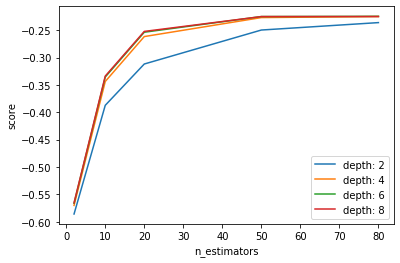

<Figure size 432x288 with 0 Axes>

In [28]:
%matplotlib inline
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):

    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('score')

pyplot.show()
pyplot.savefig('n_estimators_vs_max_depth.png')

#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

TODO :  GPU utilization low. Check on that